In [1]:
import os
import pandas as pd
import numpy as np
import collections
import xgboost as xgb

In [2]:
import matplotlib.pyplot as plt
from xgboost import plot_importance
from xgboost import plot_tree

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

## GENE

### 测试一个

In [5]:
data_1 = pd.read_csv("../2_data/gene/single_feature/ISONIAZID.csv")

In [6]:
data_1.head()

,Rv1044,dapC,Rv0383c,Rv0303,lprG,Rv2325c,Rv2229c,adhC,sseA,ask,lppT,Rv1209,scpA,fdhF,Rv1700,Rv1730c,mog,Rv3353c,moaE1,leuS,Rv0377,lprN,eccB4,nmtR,Rv1217c,desA2,embC,rplY,Rv1866,moaC3,folP1,Rv1732c,dapF,Rv3912,purB,truA,Rv0121c,regX3,Rv0769,whiB1,hpx,recB,rplS,Rv2019,atpD,Rv1232c,drrA,lysS,Rv2828A,Rv1109c,ctpV,hab,mazF3,moaB2,Rv3114,...,Rv2204c,Rv0378,lprB,Rv3725,Rv0941c,cspA,Rv1006,Rv0877,Rv3041c,Rv3057c,Rv0862c,Rv2699c,rpsF,Rv3237c,Rv1958c,fabG1 upstream,Rv2867c,nuoC,Rv0600c,rpoB,fadD31,rpsR1,mazE2,Rv3254,Rv3788,Rv3304,Rv3594,ephB,Rv2084,pitA,hemE,ruvA,vapB8,Rv3773c,Rv2190c,Rv2406c,Rv1895,moaA1,Rv2630,Rv2372c,metE,relF,Rv1639c,ppk2,Rv0471c,Rv1914c,pyrE,mce1R,mfd,Rv2239c,vapB27,esxH,ansP1,echA1,label
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,1,3,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,2,0,0,0,0,1,1,0,0,0,0,1,1
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,2,0,0,0,0,1,1,0,0,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,3,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2,1


In [9]:
X = data[data.columns[:-1]]
X

,Rv1044,dapC,Rv0383c,Rv0303,lprG,Rv2325c,Rv2229c,adhC,sseA,ask,lppT,Rv1209,scpA,fdhF,Rv1700,Rv1730c,mog,Rv3353c,moaE1,leuS,Rv0377,lprN,eccB4,nmtR,Rv1217c,desA2,embC,rplY,Rv1866,moaC3,folP1,Rv1732c,dapF,Rv3912,purB,truA,Rv0121c,regX3,Rv0769,whiB1,hpx,recB,rplS,Rv2019,atpD,Rv1232c,drrA,lysS,Rv2828A,Rv1109c,ctpV,hab,mazF3,moaB2,Rv3114,...,mmpL5,Rv2204c,Rv0378,lprB,Rv3725,Rv0941c,cspA,Rv1006,Rv0877,Rv3041c,Rv3057c,Rv0862c,Rv2699c,rpsF,Rv3237c,Rv1958c,fabG1 upstream,Rv2867c,nuoC,Rv0600c,rpoB,fadD31,rpsR1,mazE2,Rv3254,Rv3788,Rv3304,Rv3594,ephB,Rv2084,pitA,hemE,ruvA,vapB8,Rv3773c,Rv2190c,Rv2406c,Rv1895,moaA1,Rv2630,Rv2372c,metE,relF,Rv1639c,ppk2,Rv0471c,Rv1914c,pyrE,mce1R,mfd,Rv2239c,vapB27,esxH,ansP1,echA1
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,2,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,1,3,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,2,0,0,0,0,1,1,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,2,0,0,0,0,1,1,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,3,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4723,0,2,0,1,0,0,0,0,1,0,0,1,0,0,0,4,0,0,0,1,0,0,1,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,2,0,1,0,1,...,3,0,0,0,2,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,2,1,0,0,0,1,0,0,1,1,1,1,0,0,1,0,0,1,5,0,0,0,0,1,0,0,0,0,2,0,0,0,0,1,1
4724,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,4,0,0,1,1,0,0,1,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,2,0,0,2,0,1,0,1,...,3,0,0,0,2,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,3,1,0,0,0,1,0,0,2,1,1,1,0,0,1,0,0,1,4,0,0,0,0,1,0,0,0,0,2,0,0,0,0,1,1
4725,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,2,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,4,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
4726,0,2,0,0,0,0,0,0,1,0,0,1,0,0,0,4,0,0,0,1,0,0,1,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,2,0,1,0,1,...,3,0,0,0,2,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,2,1,0,0,0,1,0,0,1,1,1,1,0,0,1,0,0,1,5,0,0,0,0,1,0,0,0,0,2,0,0,0,0,1,1


In [10]:
y = data[data.columns[-1]]
y

0       0
1       1
2       1
3       1
4       1
       ..
4723    1
4724    1
4725    0
4726    1
4727    0
Name: label, Length: 4728, dtype: int64

In [26]:
X = data[data.columns[:-1]]
y = data[data.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

AUC得分： 0.97


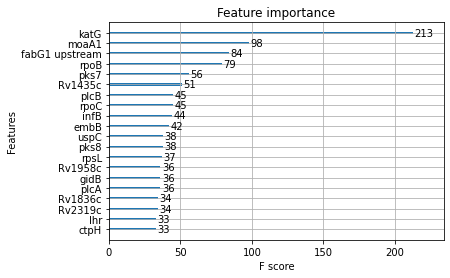

In [13]:

# set XGBoost's parameters
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',   # 回归任务设置为：'objective': 'reg:gamma',
    'gamma': 0.1,
    'max_depth': 6,
#     'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
    'gpu_id':0,
#     'eval_metric':'auc',
    'tree_method':'gpu_hist'
}


dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 500
model = xgb.train(params, dtrain, num_rounds)

# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)
auc = roc_auc_score(y_test, y_pred)
print("AUC得分： %.2f" % (auc))

# 显示重要特征
plot_importance(model, max_num_features = 20)
plt.show()

In [18]:
xgb_train = xgb.DMatrix(X_train, label = y_train)
xgb_test = xgb.DMatrix(X_test, label = y_test)

In [23]:
##自定义处理函数，解决样本悬殊问题
def fpreproc(xgb_train, xgb_test,params ):
    label = xgb_train.get_label()
    ratio = float(np.sum(label==0)/np.sum(label==1))
    params['scale_pos_weight'] = ratio
    return (xgb_train, xgb_test, params)

In [22]:
res = xgb.cv(params, xgb_train, num_rounds, nfold=5, metrics={'auc'}, seed = 0,
             callbacks={xgb.callback.print_evaluation(show_stdv=True), xgb.callback.early_stop(5)})

[0]	train-auc:0.93613+0.00389	test-auc:0.91701+0.01243
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 5 rounds.
[1]	train-auc:0.97125+0.00423	test-auc:0.95734+0.00694
[2]	train-auc:0.97369+0.00252	test-auc:0.95845+0.00739
[3]	train-auc:0.97629+0.00187	test-auc:0.96126+0.00448
[4]	train-auc:0.97909+0.00140	test-auc:0.96446+0.00192
[5]	train-auc:0.98128+0.00075	test-auc:0.96681+0.00194
[6]	train-auc:0.98313+0.00076	test-auc:0.96806+0.00224
[7]	train-auc:0.98452+0.00072	test-auc:0.96897+0.00379
[8]	train-auc:0.98540+0.00056	test-auc:0.97113+0.00341
[9]	train-auc:0.98618+0.00075	test-auc:0.97166+0.00312
[10]	train-auc:0.98630+0.00081	test-auc:0.97116+0.00261
[11]	train-auc:0.98690+0.00073	test-auc:0.97184+0.00299
[12]	train-auc:0.98732+0.00073	test-auc:0.97229+0.00283
[13]	train-auc:0.98765+0.00044	test-auc:0.97227+0.00313
[14]	train-auc:0.98817+0.00053	test-auc:0.97255+0.00321
[15]	train-auc:0.98856+0.00069

In [25]:
res = xgb.cv(params, xgb_train, num_rounds, nfold=5, metrics={'auc'}, seed = 0,
             callbacks={xgb.callback.print_evaluation(show_stdv=True), xgb.callback.early_stop(5)},fpreproc = fpreproc)

[0]	train-auc:0.94753+0.00552	test-auc:0.92141+0.00452
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 5 rounds.
[1]	train-auc:0.97469+0.00303	test-auc:0.96021+0.00513
[2]	train-auc:0.97923+0.00205	test-auc:0.96486+0.00520
[3]	train-auc:0.98068+0.00208	test-auc:0.96630+0.00494
[4]	train-auc:0.98273+0.00183	test-auc:0.96722+0.00330
[5]	train-auc:0.98442+0.00162	test-auc:0.96825+0.00386
[6]	train-auc:0.98561+0.00075	test-auc:0.96792+0.00349
[7]	train-auc:0.98630+0.00068	test-auc:0.96835+0.00460
[8]	train-auc:0.98715+0.00054	test-auc:0.97068+0.00326
[9]	train-auc:0.98769+0.00057	test-auc:0.97135+0.00311
[10]	train-auc:0.98819+0.00052	test-auc:0.97124+0.00276
[11]	train-auc:0.98858+0.00037	test-auc:0.97195+0.00328
[12]	train-auc:0.98895+0.00040	test-auc:0.97232+0.00320
[13]	train-auc:0.98940+0.00042	test-auc:0.97277+0.00260
[14]	train-auc:0.98972+0.00048	test-auc:0.97318+0.00299
[15]	train-auc:0.98998+0.00057

In [28]:
type(res)

pandas.core.frame.DataFrame

In [33]:
res

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.947527,0.005523,0.921409,0.004518
1,0.974695,0.003027,0.960206,0.005128
2,0.979231,0.002046,0.964858,0.005198
3,0.980675,0.002083,0.966303,0.004944
4,0.982725,0.001827,0.967222,0.003302
5,0.984422,0.001621,0.968254,0.003855
6,0.985605,0.000751,0.967922,0.003486
7,0.986303,0.000679,0.968351,0.004602
8,0.987147,0.000537,0.970679,0.003263
9,0.987687,0.000571,0.971350,0.003110


In [29]:
watchlist = {(xgb_train, 'train'), (xgb_test, 'eval')}

In [30]:
evals_result = {}
model = xgb.train(params, dtrain, num_rounds,watchlist, evals_result =evals_result)

[0]	eval-auc:0.90455	train-auc:0.93751
[1]	eval-auc:0.95065	train-auc:0.96564
[2]	eval-auc:0.95570	train-auc:0.97680
[3]	eval-auc:0.95669	train-auc:0.98003
[4]	eval-auc:0.96054	train-auc:0.98122
[5]	eval-auc:0.95941	train-auc:0.98111
[6]	eval-auc:0.96042	train-auc:0.98323
[7]	eval-auc:0.96154	train-auc:0.98459
[8]	eval-auc:0.96298	train-auc:0.98567
[9]	eval-auc:0.96294	train-auc:0.98703
[10]	eval-auc:0.96199	train-auc:0.98730
[11]	eval-auc:0.96394	train-auc:0.98807
[12]	eval-auc:0.96347	train-auc:0.98819
[13]	eval-auc:0.96409	train-auc:0.98845
[14]	eval-auc:0.96449	train-auc:0.98911
[15]	eval-auc:0.96447	train-auc:0.98926
[16]	eval-auc:0.96460	train-auc:0.98947
[17]	eval-auc:0.96517	train-auc:0.98966
[18]	eval-auc:0.96489	train-auc:0.98986
[19]	eval-auc:0.96508	train-auc:0.99000
[20]	eval-auc:0.96549	train-auc:0.99015
[21]	eval-auc:0.96626	train-auc:0.99019
[22]	eval-auc:0.96595	train-auc:0.99059
[23]	eval-auc:0.96601	train-auc:0.99069
[24]	eval-auc:0.96585	train-auc:0.99100
[25]	eval-

[203]	eval-auc:0.96748	train-auc:0.99967
[204]	eval-auc:0.96748	train-auc:0.99967
[205]	eval-auc:0.96747	train-auc:0.99968
[206]	eval-auc:0.96749	train-auc:0.99969
[207]	eval-auc:0.96748	train-auc:0.99970
[208]	eval-auc:0.96748	train-auc:0.99970
[209]	eval-auc:0.96751	train-auc:0.99969
[210]	eval-auc:0.96763	train-auc:0.99970
[211]	eval-auc:0.96773	train-auc:0.99970
[212]	eval-auc:0.96785	train-auc:0.99971
[213]	eval-auc:0.96771	train-auc:0.99971
[214]	eval-auc:0.96762	train-auc:0.99972
[215]	eval-auc:0.96761	train-auc:0.99972
[216]	eval-auc:0.96768	train-auc:0.99974
[217]	eval-auc:0.96775	train-auc:0.99975
[218]	eval-auc:0.96763	train-auc:0.99976
[219]	eval-auc:0.96773	train-auc:0.99976
[220]	eval-auc:0.96766	train-auc:0.99977
[221]	eval-auc:0.96748	train-auc:0.99978
[222]	eval-auc:0.96755	train-auc:0.99979
[223]	eval-auc:0.96742	train-auc:0.99979
[224]	eval-auc:0.96754	train-auc:0.99980
[225]	eval-auc:0.96751	train-auc:0.99980
[226]	eval-auc:0.96744	train-auc:0.99981
[227]	eval-auc:0

[403]	eval-auc:0.96691	train-auc:0.99999
[404]	eval-auc:0.96693	train-auc:0.99999
[405]	eval-auc:0.96700	train-auc:0.99999
[406]	eval-auc:0.96702	train-auc:0.99999
[407]	eval-auc:0.96699	train-auc:0.99999
[408]	eval-auc:0.96700	train-auc:0.99999
[409]	eval-auc:0.96695	train-auc:0.99999
[410]	eval-auc:0.96688	train-auc:0.99999
[411]	eval-auc:0.96684	train-auc:0.99999
[412]	eval-auc:0.96668	train-auc:0.99999
[413]	eval-auc:0.96680	train-auc:0.99999
[414]	eval-auc:0.96682	train-auc:0.99999
[415]	eval-auc:0.96685	train-auc:0.99999
[416]	eval-auc:0.96694	train-auc:0.99999
[417]	eval-auc:0.96684	train-auc:0.99999
[418]	eval-auc:0.96683	train-auc:0.99999
[419]	eval-auc:0.96677	train-auc:0.99999
[420]	eval-auc:0.96678	train-auc:0.99999
[421]	eval-auc:0.96683	train-auc:0.99999
[422]	eval-auc:0.96692	train-auc:0.99999
[423]	eval-auc:0.96687	train-auc:0.99999
[424]	eval-auc:0.96682	train-auc:0.99999
[425]	eval-auc:0.96679	train-auc:0.99999
[426]	eval-auc:0.96689	train-auc:0.99999
[427]	eval-auc:0

In [31]:
evals_result['eval']

{'auc': [0.904552,
  0.950653,
  0.955697,
  0.956685,
  0.960536,
  0.95941,
  0.960425,
  0.96154,
  0.962984,
  0.962937,
  0.961991,
  0.963937,
  0.96347,
  0.964086,
  0.964487,
  0.964467,
  0.9646,
  0.965169,
  0.964895,
  0.965081,
  0.965493,
  0.966259,
  0.965948,
  0.966007,
  0.965846,
  0.96643,
  0.966613,
  0.966392,
  0.966706,
  0.966807,
  0.966697,
  0.966725,
  0.966635,
  0.966808,
  0.967325,
  0.967429,
  0.967884,
  0.967994,
  0.96796,
  0.968114,
  0.968171,
  0.968594,
  0.96862,
  0.968849,
  0.968569,
  0.968527,
  0.968714,
  0.968864,
  0.968689,
  0.968203,
  0.968066,
  0.968015,
  0.967988,
  0.967893,
  0.96799,
  0.968068,
  0.967872,
  0.967903,
  0.967716,
  0.967929,
  0.967988,
  0.968116,
  0.968261,
  0.96839,
  0.968122,
  0.967945,
  0.967693,
  0.967625,
  0.967667,
  0.967781,
  0.96788,
  0.967853,
  0.967669,
  0.967345,
  0.96721,
  0.967278,
  0.967208,
  0.967497,
  0.967695,
  0.968093,
  0.967931,
  0.967859,
  0.967927,
  0.96794

In [4]:
import os

In [5]:
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',   # 回归任务设置为：'objective': 'reg:gamma',
    'gamma': 0.1,
    'max_depth': 6,
#     'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
    'gpu_id':0,
#     'eval_metric':'auc',
    'tree_method':'gpu_hist'
}


dtrain = xgb.DMatrix(X_train, y_train)
num_rounds = 500
model = xgb.train(params, dtrain, num_rounds)

NameError: name 'X_train' is not defined

In [11]:
basePath = '../2_data/gene/single_feature/'

for f in os.listdir(basePath):
    data = pd.read_csv(basePath+f)
    
    X = data[data.columns[:-1]]
    y = data[data.columns[-1]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
    
    params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',   # 回归任务设置为：'objective': 'reg:gamma',
    'gamma': 0.1,
    'max_depth': 6,
#     'lambda': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3,
    'eta': 0.1,
    'seed': 1000,
    'nthread': 4,
    'gpu_id':0,
#     'eval_metric':'auc',
    'tree_method':'gpu_hist'
    }
    
    xgb_train = xgb.DMatrix(X_train, label = y_train)
    xgb_test = xgb.DMatrix(X_test, label = y_test)
    
    num_rounds = 500
    watchlist = {(xgb_train, 'train'), (xgb_test, 'eval')}
    
    res = xgb.cv(params, xgb_train, num_rounds, nfold=5, metrics={'auc'}, seed = 0,
             callbacks={xgb.callback.print_evaluation(show_stdv=True), xgb.callback.early_stop(5)})
    res.to_csv("../2_data/gene/res/"+f, index= False)
#     dtrain = xgb.DMatrix(X_train, y_train)
    evals_result = {}
    model = xgb.train(params, xgb_train, num_rounds,watchlist, evals_result =evals_result)
    importance = model.get_fscore()
    df=pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore']/df['fscore'].sum()
    df.to_csv("../2_data/gene/importance/"+f)

[0]	train-auc:0.84396+0.01633	test-auc:0.74176+0.04699
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 5 rounds.
[1]	train-auc:0.92945+0.01215	test-auc:0.85864+0.03718
[2]	train-auc:0.93945+0.01051	test-auc:0.86043+0.02242
[3]	train-auc:0.95167+0.00617	test-auc:0.87603+0.02708
[4]	train-auc:0.95868+0.00341	test-auc:0.88108+0.02986
[5]	train-auc:0.96259+0.00355	test-auc:0.88381+0.03434
[6]	train-auc:0.96452+0.00367	test-auc:0.88882+0.03922
[7]	train-auc:0.96556+0.00321	test-auc:0.89411+0.03669
[8]	train-auc:0.96680+0.00371	test-auc:0.90159+0.03897
[9]	train-auc:0.96865+0.00286	test-auc:0.90047+0.04259
[10]	train-auc:0.96986+0.00328	test-auc:0.90013+0.04348
[11]	train-auc:0.97080+0.00332	test-auc:0.90001+0.04703
[12]	train-auc:0.97203+0.00313	test-auc:0.90352+0.04586
[13]	train-auc:0.97285+0.00324	test-auc:0.90316+0.04824
[14]	train-auc:0.97410+0.00323	test-auc:0.90356+0.04886
[15]	train-auc:0.97453+0.00319

[133]	train-error:0.01872	eval-error:0.05694
[134]	train-error:0.01872	eval-error:0.05694
[135]	train-error:0.01872	eval-error:0.05694
[136]	train-error:0.01872	eval-error:0.05694
[137]	train-error:0.01783	eval-error:0.05694
[138]	train-error:0.01783	eval-error:0.05694
[139]	train-error:0.01693	eval-error:0.05694
[140]	train-error:0.01693	eval-error:0.05694
[141]	train-error:0.01783	eval-error:0.05694
[142]	train-error:0.01515	eval-error:0.05694
[143]	train-error:0.01604	eval-error:0.05694
[144]	train-error:0.01604	eval-error:0.05694
[145]	train-error:0.01604	eval-error:0.05694
[146]	train-error:0.01515	eval-error:0.05694
[147]	train-error:0.01515	eval-error:0.05694
[148]	train-error:0.01515	eval-error:0.05694
[149]	train-error:0.01426	eval-error:0.05694
[150]	train-error:0.01426	eval-error:0.05694
[151]	train-error:0.01426	eval-error:0.05694
[152]	train-error:0.01426	eval-error:0.05694
[153]	train-error:0.01426	eval-error:0.05694
[154]	train-error:0.01426	eval-error:0.05694
[155]	trai

[316]	train-error:0.00535	eval-error:0.05694
[317]	train-error:0.00446	eval-error:0.05694
[318]	train-error:0.00446	eval-error:0.05694
[319]	train-error:0.00446	eval-error:0.05694
[320]	train-error:0.00535	eval-error:0.05694
[321]	train-error:0.00535	eval-error:0.05694
[322]	train-error:0.00535	eval-error:0.05694
[323]	train-error:0.00535	eval-error:0.05694
[324]	train-error:0.00535	eval-error:0.05694
[325]	train-error:0.00535	eval-error:0.05694
[326]	train-error:0.00535	eval-error:0.05694
[327]	train-error:0.00535	eval-error:0.05694
[328]	train-error:0.00535	eval-error:0.05694
[329]	train-error:0.00446	eval-error:0.05694
[330]	train-error:0.00446	eval-error:0.05694
[331]	train-error:0.00446	eval-error:0.05694
[332]	train-error:0.00535	eval-error:0.05694
[333]	train-error:0.00446	eval-error:0.05694
[334]	train-error:0.00446	eval-error:0.05694
[335]	train-error:0.00446	eval-error:0.05694
[336]	train-error:0.00446	eval-error:0.05694
[337]	train-error:0.00446	eval-error:0.05694
[338]	trai

[499]	train-error:0.00089	eval-error:0.06050
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 5 rounds.
[0]	train-auc:0.80248+0.01947	test-auc:0.72895+0.06158
[1]	train-auc:0.89199+0.01587	test-auc:0.82062+0.04912
[2]	train-auc:0.90946+0.01353	test-auc:0.82461+0.05118
[3]	train-auc:0.92151+0.01157	test-auc:0.81782+0.04916
[4]	train-auc:0.92548+0.00913	test-auc:0.82071+0.05047
[5]	train-auc:0.93327+0.00905	test-auc:0.83090+0.04834
[6]	train-auc:0.93967+0.00838	test-auc:0.83725+0.04991
[7]	train-auc:0.94235+0.00726	test-auc:0.83718+0.04808
[8]	train-auc:0.94491+0.00651	test-auc:0.83712+0.04362
[9]	train-auc:0.94789+0.00566	test-auc:0.84078+0.04363
[10]	train-auc:0.95178+0.00570	test-auc:0.84449+0.03688
[11]	train-auc:0.95451+0.00410	test-auc:0.84760+0.04066
[12]	train-auc:0.95535+0.00417	test-auc:0.84946+0.04215
[13]	train-auc:0.95639+0.00345	test-auc:0.84939+0.04117
[14]	train-auc:0.95838+0.00324	test-auc:0

[139]	train-error:0.02271	eval-error:0.08459
[140]	train-error:0.02271	eval-error:0.08459
[141]	train-error:0.02271	eval-error:0.08459
[142]	train-error:0.02271	eval-error:0.08761
[143]	train-error:0.02195	eval-error:0.08761
[144]	train-error:0.02271	eval-error:0.08761
[145]	train-error:0.02271	eval-error:0.08761
[146]	train-error:0.02271	eval-error:0.08761
[147]	train-error:0.02271	eval-error:0.08761
[148]	train-error:0.02271	eval-error:0.08761
[149]	train-error:0.02195	eval-error:0.08761
[150]	train-error:0.01968	eval-error:0.08761
[151]	train-error:0.02044	eval-error:0.08761
[152]	train-error:0.02120	eval-error:0.09063
[153]	train-error:0.02120	eval-error:0.09063
[154]	train-error:0.02120	eval-error:0.09063
[155]	train-error:0.02195	eval-error:0.09063
[156]	train-error:0.02195	eval-error:0.09063
[157]	train-error:0.02120	eval-error:0.09063
[158]	train-error:0.02044	eval-error:0.09063
[159]	train-error:0.01968	eval-error:0.08761
[160]	train-error:0.01968	eval-error:0.09063
[161]	trai

[322]	train-error:0.00379	eval-error:0.09063
[323]	train-error:0.00379	eval-error:0.09063
[324]	train-error:0.00379	eval-error:0.09063
[325]	train-error:0.00379	eval-error:0.08761
[326]	train-error:0.00379	eval-error:0.08761
[327]	train-error:0.00379	eval-error:0.08761
[328]	train-error:0.00379	eval-error:0.09063
[329]	train-error:0.00379	eval-error:0.09063
[330]	train-error:0.00379	eval-error:0.09063
[331]	train-error:0.00379	eval-error:0.09063
[332]	train-error:0.00379	eval-error:0.09063
[333]	train-error:0.00379	eval-error:0.09063
[334]	train-error:0.00379	eval-error:0.09063
[335]	train-error:0.00379	eval-error:0.09063
[336]	train-error:0.00379	eval-error:0.09063
[337]	train-error:0.00379	eval-error:0.09063
[338]	train-error:0.00379	eval-error:0.09063
[339]	train-error:0.00379	eval-error:0.08761
[340]	train-error:0.00379	eval-error:0.09063
[341]	train-error:0.00379	eval-error:0.09063
[342]	train-error:0.00379	eval-error:0.08761
[343]	train-error:0.00379	eval-error:0.09063
[344]	trai

[1]	train-auc:0.94473+0.01474	test-auc:0.88991+0.06073
[2]	train-auc:0.95627+0.01565	test-auc:0.90855+0.04489
[3]	train-auc:0.96546+0.01034	test-auc:0.91493+0.05363
[4]	train-auc:0.97055+0.01097	test-auc:0.92542+0.05361
[5]	train-auc:0.97396+0.00678	test-auc:0.92668+0.05507
[6]	train-auc:0.97568+0.00481	test-auc:0.92196+0.05293
[7]	train-auc:0.97606+0.00560	test-auc:0.92902+0.04227
[8]	train-auc:0.97782+0.00623	test-auc:0.93147+0.04214
[9]	train-auc:0.98390+0.00539	test-auc:0.94578+0.03689
[10]	train-auc:0.98427+0.00623	test-auc:0.94895+0.03679
[11]	train-auc:0.98531+0.00566	test-auc:0.94935+0.03390
[12]	train-auc:0.98810+0.00504	test-auc:0.94802+0.03696
[13]	train-auc:0.98894+0.00296	test-auc:0.95044+0.03410
[14]	train-auc:0.98766+0.00239	test-auc:0.95071+0.03456
[15]	train-auc:0.98908+0.00258	test-auc:0.95253+0.03522
[16]	train-auc:0.99090+0.00314	test-auc:0.95745+0.03218
[17]	train-auc:0.99171+0.00327	test-auc:0.95909+0.03075
[18]	train-auc:0.99202+0.00349	test-auc:0.95778+0.03243
[

[141]	eval-error:0.02778	train-error:0.01049
[142]	eval-error:0.02778	train-error:0.01049
[143]	eval-error:0.02778	train-error:0.01049
[144]	eval-error:0.02778	train-error:0.01049
[145]	eval-error:0.02778	train-error:0.00699
[146]	eval-error:0.02778	train-error:0.00699
[147]	eval-error:0.02778	train-error:0.01049
[148]	eval-error:0.02778	train-error:0.00699
[149]	eval-error:0.02778	train-error:0.01049
[150]	eval-error:0.02778	train-error:0.01049
[151]	eval-error:0.02778	train-error:0.00699
[152]	eval-error:0.02778	train-error:0.01049
[153]	eval-error:0.02778	train-error:0.01049
[154]	eval-error:0.02778	train-error:0.00699
[155]	eval-error:0.02778	train-error:0.01049
[156]	eval-error:0.02778	train-error:0.00699
[157]	eval-error:0.02778	train-error:0.00699
[158]	eval-error:0.02778	train-error:0.00699
[159]	eval-error:0.02778	train-error:0.00699
[160]	eval-error:0.02778	train-error:0.00699
[161]	eval-error:0.02778	train-error:0.00699
[162]	eval-error:0.02778	train-error:0.00699
[163]	eval

[324]	eval-error:0.01389	train-error:0.00350
[325]	eval-error:0.02778	train-error:0.00350
[326]	eval-error:0.02778	train-error:0.00350
[327]	eval-error:0.02778	train-error:0.00350
[328]	eval-error:0.01389	train-error:0.00350
[329]	eval-error:0.01389	train-error:0.00350
[330]	eval-error:0.01389	train-error:0.00350
[331]	eval-error:0.01389	train-error:0.00350
[332]	eval-error:0.01389	train-error:0.00350
[333]	eval-error:0.01389	train-error:0.00350
[334]	eval-error:0.01389	train-error:0.00350
[335]	eval-error:0.01389	train-error:0.00350
[336]	eval-error:0.01389	train-error:0.00350
[337]	eval-error:0.01389	train-error:0.00350
[338]	eval-error:0.01389	train-error:0.00350
[339]	eval-error:0.01389	train-error:0.00350
[340]	eval-error:0.01389	train-error:0.00350
[341]	eval-error:0.01389	train-error:0.00350
[342]	eval-error:0.01389	train-error:0.00350
[343]	eval-error:0.01389	train-error:0.00350
[344]	eval-error:0.01389	train-error:0.00350
[345]	eval-error:0.01389	train-error:0.00350
[346]	eval

[3]	train-auc:0.95194+0.00987	test-auc:0.89928+0.07302
[4]	train-auc:0.95137+0.01398	test-auc:0.90789+0.07049
[5]	train-auc:0.95382+0.00986	test-auc:0.91580+0.07813
Stopping. Best iteration:
[1]	train-auc:0.91348+0.02451	test-auc:0.91925+0.07061

[0]	train-error:0.16268	eval-error:0.22642
[1]	train-error:0.11005	eval-error:0.15094
[2]	train-error:0.10526	eval-error:0.22642
[3]	train-error:0.10526	eval-error:0.15094
[4]	train-error:0.09569	eval-error:0.15094
[5]	train-error:0.10048	eval-error:0.15094
[6]	train-error:0.09091	eval-error:0.15094
[7]	train-error:0.09091	eval-error:0.16981
[8]	train-error:0.09569	eval-error:0.15094
[9]	train-error:0.09569	eval-error:0.15094
[10]	train-error:0.09569	eval-error:0.15094
[11]	train-error:0.09091	eval-error:0.15094
[12]	train-error:0.09091	eval-error:0.15094
[13]	train-error:0.08612	eval-error:0.15094
[14]	train-error:0.08134	eval-error:0.15094
[15]	train-error:0.09569	eval-error:0.18868
[16]	train-error:0.07655	eval-error:0.18868
[17]	train-erro

[180]	train-error:0.03349	eval-error:0.22642
[181]	train-error:0.03349	eval-error:0.22642
[182]	train-error:0.03349	eval-error:0.22642
[183]	train-error:0.03349	eval-error:0.22642
[184]	train-error:0.03349	eval-error:0.22642
[185]	train-error:0.03349	eval-error:0.22642
[186]	train-error:0.03828	eval-error:0.22642
[187]	train-error:0.03828	eval-error:0.22642
[188]	train-error:0.03349	eval-error:0.22642
[189]	train-error:0.03349	eval-error:0.22642
[190]	train-error:0.03349	eval-error:0.22642
[191]	train-error:0.03828	eval-error:0.22642
[192]	train-error:0.03828	eval-error:0.22642
[193]	train-error:0.03349	eval-error:0.24528
[194]	train-error:0.03828	eval-error:0.24528
[195]	train-error:0.03828	eval-error:0.22642
[196]	train-error:0.03828	eval-error:0.22642
[197]	train-error:0.03828	eval-error:0.22642
[198]	train-error:0.03349	eval-error:0.22642
[199]	train-error:0.02871	eval-error:0.22642
[200]	train-error:0.02871	eval-error:0.22642
[201]	train-error:0.03828	eval-error:0.22642
[202]	trai

[363]	train-error:0.02871	eval-error:0.18868
[364]	train-error:0.02871	eval-error:0.20755
[365]	train-error:0.02871	eval-error:0.20755
[366]	train-error:0.02871	eval-error:0.20755
[367]	train-error:0.02871	eval-error:0.20755
[368]	train-error:0.02871	eval-error:0.20755
[369]	train-error:0.02871	eval-error:0.18868
[370]	train-error:0.02392	eval-error:0.18868
[371]	train-error:0.02392	eval-error:0.18868
[372]	train-error:0.02392	eval-error:0.18868
[373]	train-error:0.02392	eval-error:0.18868
[374]	train-error:0.02392	eval-error:0.18868
[375]	train-error:0.02392	eval-error:0.18868
[376]	train-error:0.02392	eval-error:0.18868
[377]	train-error:0.02392	eval-error:0.18868
[378]	train-error:0.02392	eval-error:0.18868
[379]	train-error:0.02392	eval-error:0.18868
[380]	train-error:0.02392	eval-error:0.18868
[381]	train-error:0.02392	eval-error:0.18868
[382]	train-error:0.02392	eval-error:0.18868
[383]	train-error:0.02392	eval-error:0.18868
[384]	train-error:0.02871	eval-error:0.18868
[385]	trai

[20]	train-error:0.13115	eval-error:0.06250
[21]	train-error:0.13115	eval-error:0.06250
[22]	train-error:0.13115	eval-error:0.06250
[23]	train-error:0.13115	eval-error:0.06250
[24]	train-error:0.13115	eval-error:0.06250
[25]	train-error:0.13115	eval-error:0.06250
[26]	train-error:0.13115	eval-error:0.06250
[27]	train-error:0.13115	eval-error:0.06250
[28]	train-error:0.13115	eval-error:0.06250
[29]	train-error:0.13115	eval-error:0.06250
[30]	train-error:0.13115	eval-error:0.06250
[31]	train-error:0.13115	eval-error:0.06250
[32]	train-error:0.13115	eval-error:0.06250
[33]	train-error:0.13115	eval-error:0.06250
[34]	train-error:0.13115	eval-error:0.06250
[35]	train-error:0.13115	eval-error:0.06250
[36]	train-error:0.13115	eval-error:0.06250
[37]	train-error:0.13115	eval-error:0.06250
[38]	train-error:0.13115	eval-error:0.06250
[39]	train-error:0.13115	eval-error:0.06250
[40]	train-error:0.13115	eval-error:0.06250
[41]	train-error:0.13115	eval-error:0.06250
[42]	train-error:0.13115	eval-er

[204]	train-error:0.13115	eval-error:0.06250
[205]	train-error:0.13115	eval-error:0.06250
[206]	train-error:0.13115	eval-error:0.06250
[207]	train-error:0.13115	eval-error:0.06250
[208]	train-error:0.13115	eval-error:0.06250
[209]	train-error:0.13115	eval-error:0.06250
[210]	train-error:0.13115	eval-error:0.06250
[211]	train-error:0.13115	eval-error:0.06250
[212]	train-error:0.13115	eval-error:0.06250
[213]	train-error:0.13115	eval-error:0.06250
[214]	train-error:0.13115	eval-error:0.06250
[215]	train-error:0.13115	eval-error:0.06250
[216]	train-error:0.13115	eval-error:0.06250
[217]	train-error:0.13115	eval-error:0.06250
[218]	train-error:0.13115	eval-error:0.06250
[219]	train-error:0.13115	eval-error:0.06250
[220]	train-error:0.13115	eval-error:0.06250
[221]	train-error:0.13115	eval-error:0.06250
[222]	train-error:0.13115	eval-error:0.06250
[223]	train-error:0.13115	eval-error:0.06250
[224]	train-error:0.13115	eval-error:0.06250
[225]	train-error:0.13115	eval-error:0.06250
[226]	trai

[387]	train-error:0.13115	eval-error:0.06250
[388]	train-error:0.13115	eval-error:0.06250
[389]	train-error:0.13115	eval-error:0.06250
[390]	train-error:0.13115	eval-error:0.06250
[391]	train-error:0.13115	eval-error:0.06250
[392]	train-error:0.13115	eval-error:0.06250
[393]	train-error:0.13115	eval-error:0.06250
[394]	train-error:0.13115	eval-error:0.06250
[395]	train-error:0.13115	eval-error:0.06250
[396]	train-error:0.13115	eval-error:0.06250
[397]	train-error:0.13115	eval-error:0.06250
[398]	train-error:0.13115	eval-error:0.06250
[399]	train-error:0.13115	eval-error:0.06250
[400]	train-error:0.13115	eval-error:0.06250
[401]	train-error:0.13115	eval-error:0.06250
[402]	train-error:0.13115	eval-error:0.06250
[403]	train-error:0.13115	eval-error:0.06250
[404]	train-error:0.13115	eval-error:0.06250
[405]	train-error:0.13115	eval-error:0.06250
[406]	train-error:0.13115	eval-error:0.06250
[407]	train-error:0.13115	eval-error:0.06250
[408]	train-error:0.13115	eval-error:0.06250
[409]	trai

[37]	train-error:0.05457	eval-error:0.16026
[38]	train-error:0.04494	eval-error:0.15385
[39]	train-error:0.04334	eval-error:0.14103
[40]	train-error:0.04013	eval-error:0.14103
[41]	train-error:0.04173	eval-error:0.14103
[42]	train-error:0.04334	eval-error:0.14103
[43]	train-error:0.04494	eval-error:0.14744
[44]	train-error:0.04494	eval-error:0.14103
[45]	train-error:0.04334	eval-error:0.14103
[46]	train-error:0.04013	eval-error:0.13462
[47]	train-error:0.03852	eval-error:0.13462
[48]	train-error:0.03531	eval-error:0.14744
[49]	train-error:0.03692	eval-error:0.14744
[50]	train-error:0.03692	eval-error:0.14103
[51]	train-error:0.03531	eval-error:0.14103
[52]	train-error:0.03692	eval-error:0.14103
[53]	train-error:0.03692	eval-error:0.14103
[54]	train-error:0.04013	eval-error:0.13462
[55]	train-error:0.03531	eval-error:0.13462
[56]	train-error:0.03852	eval-error:0.14103
[57]	train-error:0.03692	eval-error:0.13462
[58]	train-error:0.03371	eval-error:0.13462
[59]	train-error:0.03371	eval-er

[221]	train-error:0.00642	eval-error:0.11539
[222]	train-error:0.00642	eval-error:0.11539
[223]	train-error:0.00642	eval-error:0.11539
[224]	train-error:0.00481	eval-error:0.11539
[225]	train-error:0.00481	eval-error:0.11539
[226]	train-error:0.00481	eval-error:0.11539
[227]	train-error:0.00481	eval-error:0.12180
[228]	train-error:0.00642	eval-error:0.12180
[229]	train-error:0.00642	eval-error:0.12180
[230]	train-error:0.00642	eval-error:0.12180
[231]	train-error:0.00642	eval-error:0.12180
[232]	train-error:0.00481	eval-error:0.12180
[233]	train-error:0.00642	eval-error:0.12821
[234]	train-error:0.00642	eval-error:0.12821
[235]	train-error:0.00642	eval-error:0.12821
[236]	train-error:0.00803	eval-error:0.12821
[237]	train-error:0.00803	eval-error:0.12821
[238]	train-error:0.00642	eval-error:0.12821
[239]	train-error:0.00803	eval-error:0.12821
[240]	train-error:0.00803	eval-error:0.12821
[241]	train-error:0.00803	eval-error:0.12821
[242]	train-error:0.00803	eval-error:0.12821
[243]	trai

[404]	train-error:0.00161	eval-error:0.12180
[405]	train-error:0.00161	eval-error:0.12180
[406]	train-error:0.00161	eval-error:0.12180
[407]	train-error:0.00161	eval-error:0.12180
[408]	train-error:0.00161	eval-error:0.12180
[409]	train-error:0.00161	eval-error:0.12180
[410]	train-error:0.00161	eval-error:0.12180
[411]	train-error:0.00161	eval-error:0.12180
[412]	train-error:0.00161	eval-error:0.12180
[413]	train-error:0.00161	eval-error:0.12180
[414]	train-error:0.00161	eval-error:0.12180
[415]	train-error:0.00161	eval-error:0.12180
[416]	train-error:0.00161	eval-error:0.12180
[417]	train-error:0.00161	eval-error:0.12180
[418]	train-error:0.00161	eval-error:0.12180
[419]	train-error:0.00161	eval-error:0.12180
[420]	train-error:0.00000	eval-error:0.12180
[421]	train-error:0.00161	eval-error:0.12180
[422]	train-error:0.00161	eval-error:0.12180
[423]	train-error:0.00161	eval-error:0.12180
[424]	train-error:0.00161	eval-error:0.12180
[425]	train-error:0.00161	eval-error:0.12180
[426]	trai

[25]	eval-error:0.06765	train-error:0.04918
[26]	eval-error:0.06871	train-error:0.04865
[27]	eval-error:0.06871	train-error:0.04839
[28]	eval-error:0.06765	train-error:0.04759
[29]	eval-error:0.06765	train-error:0.04707
[30]	eval-error:0.06765	train-error:0.04786
[31]	eval-error:0.06660	train-error:0.04627
[32]	eval-error:0.06765	train-error:0.04574
[33]	eval-error:0.06871	train-error:0.04574
[34]	eval-error:0.06765	train-error:0.04601
[35]	eval-error:0.06977	train-error:0.04548
[36]	eval-error:0.06765	train-error:0.04495
[37]	eval-error:0.06765	train-error:0.04469
[38]	eval-error:0.06765	train-error:0.04363
[39]	eval-error:0.06765	train-error:0.04336
[40]	eval-error:0.06660	train-error:0.04363
[41]	eval-error:0.06554	train-error:0.04283
[42]	eval-error:0.06554	train-error:0.04310
[43]	eval-error:0.06660	train-error:0.04231
[44]	eval-error:0.06660	train-error:0.04178
[45]	eval-error:0.06554	train-error:0.04125
[46]	eval-error:0.06660	train-error:0.04151
[47]	eval-error:0.06554	train-er

[209]	eval-error:0.06448	train-error:0.00873
[210]	eval-error:0.06448	train-error:0.00873
[211]	eval-error:0.06342	train-error:0.00873
[212]	eval-error:0.06448	train-error:0.00846
[213]	eval-error:0.06342	train-error:0.00846
[214]	eval-error:0.06342	train-error:0.00793
[215]	eval-error:0.06342	train-error:0.00820
[216]	eval-error:0.06342	train-error:0.00820
[217]	eval-error:0.06342	train-error:0.00767
[218]	eval-error:0.06342	train-error:0.00793
[219]	eval-error:0.06237	train-error:0.00767
[220]	eval-error:0.06237	train-error:0.00767
[221]	eval-error:0.06237	train-error:0.00793
[222]	eval-error:0.06448	train-error:0.00793
[223]	eval-error:0.06448	train-error:0.00793
[224]	eval-error:0.06342	train-error:0.00767
[225]	eval-error:0.06342	train-error:0.00767
[226]	eval-error:0.06342	train-error:0.00793
[227]	eval-error:0.06342	train-error:0.00767
[228]	eval-error:0.06237	train-error:0.00767
[229]	eval-error:0.06342	train-error:0.00767
[230]	eval-error:0.06448	train-error:0.00767
[231]	eval

[392]	eval-error:0.06448	train-error:0.00317
[393]	eval-error:0.06448	train-error:0.00317
[394]	eval-error:0.06448	train-error:0.00317
[395]	eval-error:0.06448	train-error:0.00317
[396]	eval-error:0.06448	train-error:0.00317
[397]	eval-error:0.06448	train-error:0.00317
[398]	eval-error:0.06448	train-error:0.00317
[399]	eval-error:0.06448	train-error:0.00317
[400]	eval-error:0.06448	train-error:0.00317
[401]	eval-error:0.06448	train-error:0.00317
[402]	eval-error:0.06448	train-error:0.00317
[403]	eval-error:0.06448	train-error:0.00317
[404]	eval-error:0.06342	train-error:0.00317
[405]	eval-error:0.06448	train-error:0.00317
[406]	eval-error:0.06342	train-error:0.00291
[407]	eval-error:0.06237	train-error:0.00291
[408]	eval-error:0.06342	train-error:0.00317
[409]	eval-error:0.06448	train-error:0.00317
[410]	eval-error:0.06554	train-error:0.00291
[411]	eval-error:0.06554	train-error:0.00317
[412]	eval-error:0.06554	train-error:0.00317
[413]	eval-error:0.06554	train-error:0.00317
[414]	eval

[46]	eval-error:0.11539	train-error:0.02463
[47]	eval-error:0.11539	train-error:0.02463
[48]	eval-error:0.11111	train-error:0.02355
[49]	eval-error:0.11111	train-error:0.02355
[50]	eval-error:0.11111	train-error:0.02355
[51]	eval-error:0.11111	train-error:0.02355
[52]	eval-error:0.11111	train-error:0.02248
[53]	eval-error:0.11539	train-error:0.02248
[54]	eval-error:0.11539	train-error:0.02248
[55]	eval-error:0.11966	train-error:0.02141
[56]	eval-error:0.11966	train-error:0.02034
[57]	eval-error:0.11539	train-error:0.02248
[58]	eval-error:0.11539	train-error:0.02034
[59]	eval-error:0.11539	train-error:0.02034
[60]	eval-error:0.11966	train-error:0.02141
[61]	eval-error:0.11966	train-error:0.02248
[62]	eval-error:0.11966	train-error:0.02248
[63]	eval-error:0.11539	train-error:0.01927
[64]	eval-error:0.11539	train-error:0.01927
[65]	eval-error:0.11539	train-error:0.01927
[66]	eval-error:0.11539	train-error:0.01927
[67]	eval-error:0.11539	train-error:0.01927
[68]	eval-error:0.11539	train-er

[230]	eval-error:0.11539	train-error:0.00749
[231]	eval-error:0.11539	train-error:0.00749
[232]	eval-error:0.11539	train-error:0.00749
[233]	eval-error:0.11966	train-error:0.00749
[234]	eval-error:0.11539	train-error:0.00749
[235]	eval-error:0.11539	train-error:0.00749
[236]	eval-error:0.11539	train-error:0.00749
[237]	eval-error:0.11539	train-error:0.00642
[238]	eval-error:0.11539	train-error:0.00749
[239]	eval-error:0.11539	train-error:0.00749
[240]	eval-error:0.11539	train-error:0.00749
[241]	eval-error:0.11539	train-error:0.00642
[242]	eval-error:0.11539	train-error:0.00642
[243]	eval-error:0.11539	train-error:0.00749
[244]	eval-error:0.11539	train-error:0.00749
[245]	eval-error:0.11539	train-error:0.00749
[246]	eval-error:0.11539	train-error:0.00749
[247]	eval-error:0.11539	train-error:0.00749
[248]	eval-error:0.11111	train-error:0.00642
[249]	eval-error:0.11539	train-error:0.00642
[250]	eval-error:0.11539	train-error:0.00642
[251]	eval-error:0.11539	train-error:0.00642
[252]	eval

[413]	eval-error:0.11966	train-error:0.00428
[414]	eval-error:0.11966	train-error:0.00428
[415]	eval-error:0.11966	train-error:0.00428
[416]	eval-error:0.11966	train-error:0.00428
[417]	eval-error:0.11966	train-error:0.00428
[418]	eval-error:0.11966	train-error:0.00428
[419]	eval-error:0.11966	train-error:0.00428
[420]	eval-error:0.11966	train-error:0.00428
[421]	eval-error:0.11966	train-error:0.00428
[422]	eval-error:0.11966	train-error:0.00428
[423]	eval-error:0.11966	train-error:0.00428
[424]	eval-error:0.11966	train-error:0.00428
[425]	eval-error:0.11966	train-error:0.00428
[426]	eval-error:0.11966	train-error:0.00428
[427]	eval-error:0.11966	train-error:0.00428
[428]	eval-error:0.11966	train-error:0.00428
[429]	eval-error:0.11966	train-error:0.00428
[430]	eval-error:0.11966	train-error:0.00428
[431]	eval-error:0.11966	train-error:0.00428
[432]	eval-error:0.11966	train-error:0.00428
[433]	eval-error:0.11966	train-error:0.00428
[434]	eval-error:0.11966	train-error:0.00428
[435]	eval

[59]	eval-error:0.03947	train-error:0.04305
[60]	eval-error:0.03947	train-error:0.04305
[61]	eval-error:0.03947	train-error:0.03973
[62]	eval-error:0.03947	train-error:0.04305
[63]	eval-error:0.03947	train-error:0.04305
[64]	eval-error:0.03947	train-error:0.04305
[65]	eval-error:0.03947	train-error:0.04305
[66]	eval-error:0.03947	train-error:0.03973
[67]	eval-error:0.03947	train-error:0.04305
[68]	eval-error:0.03947	train-error:0.04305
[69]	eval-error:0.03947	train-error:0.04305
[70]	eval-error:0.03947	train-error:0.04305
[71]	eval-error:0.03947	train-error:0.03973
[72]	eval-error:0.03947	train-error:0.03642
[73]	eval-error:0.03947	train-error:0.03642
[74]	eval-error:0.03947	train-error:0.04305
[75]	eval-error:0.03947	train-error:0.03973
[76]	eval-error:0.03947	train-error:0.03973
[77]	eval-error:0.03947	train-error:0.03973
[78]	eval-error:0.03947	train-error:0.03973
[79]	eval-error:0.03947	train-error:0.03642
[80]	eval-error:0.03947	train-error:0.03973
[81]	eval-error:0.03947	train-er

[242]	eval-error:0.03947	train-error:0.01987
[243]	eval-error:0.03947	train-error:0.02318
[244]	eval-error:0.03947	train-error:0.01987
[245]	eval-error:0.03947	train-error:0.01987
[246]	eval-error:0.03947	train-error:0.01987
[247]	eval-error:0.03947	train-error:0.01987
[248]	eval-error:0.03947	train-error:0.01987
[249]	eval-error:0.03947	train-error:0.01987
[250]	eval-error:0.03947	train-error:0.01987
[251]	eval-error:0.03947	train-error:0.01987
[252]	eval-error:0.03947	train-error:0.01987
[253]	eval-error:0.03947	train-error:0.01987
[254]	eval-error:0.03947	train-error:0.01987
[255]	eval-error:0.03947	train-error:0.01987
[256]	eval-error:0.03947	train-error:0.01987
[257]	eval-error:0.03947	train-error:0.02318
[258]	eval-error:0.03947	train-error:0.02318
[259]	eval-error:0.03947	train-error:0.02318
[260]	eval-error:0.03947	train-error:0.02318
[261]	eval-error:0.05263	train-error:0.02318
[262]	eval-error:0.05263	train-error:0.02318
[263]	eval-error:0.05263	train-error:0.02318
[264]	eval

[425]	eval-error:0.03947	train-error:0.00993
[426]	eval-error:0.03947	train-error:0.00662
[427]	eval-error:0.03947	train-error:0.00662
[428]	eval-error:0.03947	train-error:0.00662
[429]	eval-error:0.03947	train-error:0.00993
[430]	eval-error:0.03947	train-error:0.00662
[431]	eval-error:0.03947	train-error:0.00662
[432]	eval-error:0.03947	train-error:0.00662
[433]	eval-error:0.03947	train-error:0.00662
[434]	eval-error:0.03947	train-error:0.00662
[435]	eval-error:0.03947	train-error:0.00662
[436]	eval-error:0.03947	train-error:0.00662
[437]	eval-error:0.03947	train-error:0.00662
[438]	eval-error:0.03947	train-error:0.00662
[439]	eval-error:0.03947	train-error:0.00662
[440]	eval-error:0.03947	train-error:0.00993
[441]	eval-error:0.03947	train-error:0.00662
[442]	eval-error:0.03947	train-error:0.00993
[443]	eval-error:0.03947	train-error:0.00662
[444]	eval-error:0.03947	train-error:0.00662
[445]	eval-error:0.03947	train-error:0.00662
[446]	eval-error:0.03947	train-error:0.00662
[447]	eval

[85]	eval-error:0.06996	train-error:0.02887
[86]	eval-error:0.06996	train-error:0.02887
[87]	eval-error:0.06996	train-error:0.02783
[88]	eval-error:0.06996	train-error:0.02783
[89]	eval-error:0.06996	train-error:0.02680
[90]	eval-error:0.06996	train-error:0.02783
[91]	eval-error:0.06996	train-error:0.02783
[92]	eval-error:0.06996	train-error:0.02783
[93]	eval-error:0.06996	train-error:0.02783
[94]	eval-error:0.07407	train-error:0.02680
[95]	eval-error:0.06996	train-error:0.02474
[96]	eval-error:0.07407	train-error:0.02577
[97]	eval-error:0.07819	train-error:0.02474
[98]	eval-error:0.08231	train-error:0.02474
[99]	eval-error:0.08231	train-error:0.02371
[100]	eval-error:0.08231	train-error:0.02371
[101]	eval-error:0.07819	train-error:0.02474
[102]	eval-error:0.07819	train-error:0.02577
[103]	eval-error:0.07819	train-error:0.02577
[104]	eval-error:0.07819	train-error:0.02474
[105]	eval-error:0.08231	train-error:0.02474
[106]	eval-error:0.08231	train-error:0.02474
[107]	eval-error:0.08231	

[268]	eval-error:0.07819	train-error:0.00206
[269]	eval-error:0.07819	train-error:0.00206
[270]	eval-error:0.07819	train-error:0.00206
[271]	eval-error:0.07819	train-error:0.00206
[272]	eval-error:0.07819	train-error:0.00206
[273]	eval-error:0.07819	train-error:0.00206
[274]	eval-error:0.07819	train-error:0.00206
[275]	eval-error:0.08231	train-error:0.00206
[276]	eval-error:0.08231	train-error:0.00206
[277]	eval-error:0.08231	train-error:0.00206
[278]	eval-error:0.08231	train-error:0.00206
[279]	eval-error:0.08231	train-error:0.00206
[280]	eval-error:0.08231	train-error:0.00206
[281]	eval-error:0.08231	train-error:0.00206
[282]	eval-error:0.08231	train-error:0.00206
[283]	eval-error:0.08231	train-error:0.00206
[284]	eval-error:0.08231	train-error:0.00206
[285]	eval-error:0.08231	train-error:0.00206
[286]	eval-error:0.08231	train-error:0.00206
[287]	eval-error:0.08231	train-error:0.00206
[288]	eval-error:0.08642	train-error:0.00206
[289]	eval-error:0.08642	train-error:0.00206
[290]	eval

[451]	eval-error:0.08231	train-error:0.00000
[452]	eval-error:0.08231	train-error:0.00000
[453]	eval-error:0.08231	train-error:0.00000
[454]	eval-error:0.08231	train-error:0.00000
[455]	eval-error:0.08231	train-error:0.00000
[456]	eval-error:0.08231	train-error:0.00000
[457]	eval-error:0.08231	train-error:0.00000
[458]	eval-error:0.08231	train-error:0.00000
[459]	eval-error:0.08231	train-error:0.00000
[460]	eval-error:0.08231	train-error:0.00000
[461]	eval-error:0.08231	train-error:0.00000
[462]	eval-error:0.08231	train-error:0.00000
[463]	eval-error:0.08231	train-error:0.00000
[464]	eval-error:0.08231	train-error:0.00000
[465]	eval-error:0.08231	train-error:0.00000
[466]	eval-error:0.08231	train-error:0.00000
[467]	eval-error:0.08231	train-error:0.00000
[468]	eval-error:0.08231	train-error:0.00000
[469]	eval-error:0.08231	train-error:0.00000
[470]	eval-error:0.08231	train-error:0.00000
[471]	eval-error:0.08231	train-error:0.00000
[472]	eval-error:0.08231	train-error:0.00000
[473]	eval

[99]	eval-error:0.09399	train-error:0.03525
[100]	eval-error:0.09138	train-error:0.03460
[101]	eval-error:0.09138	train-error:0.03460
[102]	eval-error:0.09138	train-error:0.03394
[103]	eval-error:0.09138	train-error:0.03264
[104]	eval-error:0.09138	train-error:0.03198
[105]	eval-error:0.09138	train-error:0.03264
[106]	eval-error:0.09399	train-error:0.03198
[107]	eval-error:0.09138	train-error:0.03068
[108]	eval-error:0.09138	train-error:0.03133
[109]	eval-error:0.09138	train-error:0.03133
[110]	eval-error:0.09399	train-error:0.03068
[111]	eval-error:0.09399	train-error:0.03133
[112]	eval-error:0.09399	train-error:0.03133
[113]	eval-error:0.09138	train-error:0.02937
[114]	eval-error:0.08877	train-error:0.02937
[115]	eval-error:0.08877	train-error:0.02807
[116]	eval-error:0.08877	train-error:0.02807
[117]	eval-error:0.08355	train-error:0.02807
[118]	eval-error:0.08616	train-error:0.02872
[119]	eval-error:0.08616	train-error:0.02937
[120]	eval-error:0.08616	train-error:0.02937
[121]	eval-

[282]	eval-error:0.08355	train-error:0.00588
[283]	eval-error:0.08616	train-error:0.00588
[284]	eval-error:0.08616	train-error:0.00588
[285]	eval-error:0.08616	train-error:0.00522
[286]	eval-error:0.08616	train-error:0.00588
[287]	eval-error:0.08616	train-error:0.00588
[288]	eval-error:0.08616	train-error:0.00588
[289]	eval-error:0.08616	train-error:0.00392
[290]	eval-error:0.08616	train-error:0.00522
[291]	eval-error:0.08616	train-error:0.00522
[292]	eval-error:0.08616	train-error:0.00522
[293]	eval-error:0.08355	train-error:0.00522
[294]	eval-error:0.08355	train-error:0.00457
[295]	eval-error:0.08355	train-error:0.00457
[296]	eval-error:0.08355	train-error:0.00457
[297]	eval-error:0.08355	train-error:0.00392
[298]	eval-error:0.08355	train-error:0.00392
[299]	eval-error:0.08616	train-error:0.00457
[300]	eval-error:0.08616	train-error:0.00392
[301]	eval-error:0.08616	train-error:0.00392
[302]	eval-error:0.08616	train-error:0.00457
[303]	eval-error:0.08616	train-error:0.00522
[304]	eval

[465]	eval-error:0.08355	train-error:0.00130
[466]	eval-error:0.08355	train-error:0.00130
[467]	eval-error:0.08355	train-error:0.00130
[468]	eval-error:0.08355	train-error:0.00130
[469]	eval-error:0.08355	train-error:0.00130
[470]	eval-error:0.08355	train-error:0.00130
[471]	eval-error:0.08355	train-error:0.00130
[472]	eval-error:0.08355	train-error:0.00130
[473]	eval-error:0.08355	train-error:0.00130
[474]	eval-error:0.08355	train-error:0.00130
[475]	eval-error:0.08355	train-error:0.00130
[476]	eval-error:0.08355	train-error:0.00130
[477]	eval-error:0.08355	train-error:0.00130
[478]	eval-error:0.08355	train-error:0.00196
[479]	eval-error:0.08355	train-error:0.00196
[480]	eval-error:0.08355	train-error:0.00196
[481]	eval-error:0.08355	train-error:0.00196
[482]	eval-error:0.08355	train-error:0.00196
[483]	eval-error:0.08355	train-error:0.00196
[484]	eval-error:0.08355	train-error:0.00130
[485]	eval-error:0.08355	train-error:0.00196
[486]	eval-error:0.08355	train-error:0.00130
[487]	eval

[132]	eval-error:0.05495	train-error:0.04972
[133]	eval-error:0.06593	train-error:0.04972
[134]	eval-error:0.06593	train-error:0.04420
[135]	eval-error:0.06593	train-error:0.04972
[136]	eval-error:0.06593	train-error:0.04420
[137]	eval-error:0.06593	train-error:0.04972
[138]	eval-error:0.06593	train-error:0.04696
[139]	eval-error:0.06593	train-error:0.04972
[140]	eval-error:0.06593	train-error:0.04972
[141]	eval-error:0.06593	train-error:0.04696
[142]	eval-error:0.06593	train-error:0.04696
[143]	eval-error:0.06593	train-error:0.04696
[144]	eval-error:0.05495	train-error:0.04696
[145]	eval-error:0.06593	train-error:0.04696
[146]	eval-error:0.06593	train-error:0.04972
[147]	eval-error:0.06593	train-error:0.04972
[148]	eval-error:0.06593	train-error:0.04972
[149]	eval-error:0.06593	train-error:0.04972
[150]	eval-error:0.06593	train-error:0.05525
[151]	eval-error:0.06593	train-error:0.05249
[152]	eval-error:0.06593	train-error:0.05249
[153]	eval-error:0.06593	train-error:0.05525
[154]	eval

[315]	eval-error:0.05495	train-error:0.04144
[316]	eval-error:0.05495	train-error:0.04144
[317]	eval-error:0.05495	train-error:0.03867
[318]	eval-error:0.05495	train-error:0.04144
[319]	eval-error:0.05495	train-error:0.04144
[320]	eval-error:0.05495	train-error:0.04144
[321]	eval-error:0.05495	train-error:0.03591
[322]	eval-error:0.05495	train-error:0.03867
[323]	eval-error:0.05495	train-error:0.03867
[324]	eval-error:0.05495	train-error:0.03867
[325]	eval-error:0.05495	train-error:0.03867
[326]	eval-error:0.05495	train-error:0.04144
[327]	eval-error:0.05495	train-error:0.03867
[328]	eval-error:0.05495	train-error:0.03591
[329]	eval-error:0.05495	train-error:0.03591
[330]	eval-error:0.05495	train-error:0.03591
[331]	eval-error:0.05495	train-error:0.03591
[332]	eval-error:0.05495	train-error:0.03591
[333]	eval-error:0.05495	train-error:0.03591
[334]	eval-error:0.05495	train-error:0.03591
[335]	eval-error:0.05495	train-error:0.03591
[336]	eval-error:0.05495	train-error:0.03591
[337]	eval

[498]	eval-error:0.05495	train-error:0.03039
[499]	eval-error:0.05495	train-error:0.03039
[0]	train-auc:0.71553+0.02080	test-auc:0.54054+0.08466
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 5 rounds.
[1]	train-auc:0.77630+0.01697	test-auc:0.57197+0.09197
[2]	train-auc:0.81034+0.01610	test-auc:0.61153+0.08856
[3]	train-auc:0.83159+0.01363	test-auc:0.60096+0.10296
[4]	train-auc:0.85020+0.01194	test-auc:0.59622+0.10438
[5]	train-auc:0.85735+0.01612	test-auc:0.60675+0.08268
[6]	train-auc:0.86633+0.01175	test-auc:0.60728+0.07898
[7]	train-auc:0.87714+0.01206	test-auc:0.61344+0.07553
[8]	train-auc:0.88443+0.00886	test-auc:0.61291+0.07012
[9]	train-auc:0.89227+0.00983	test-auc:0.61642+0.08072
[10]	train-auc:0.89938+0.01256	test-auc:0.61555+0.08305
[11]	train-auc:0.90769+0.01239	test-auc:0.62202+0.08214
[12]	train-auc:0.91004+0.01311	test-auc:0.62103+0.08063
[13]	train-auc:0.91552+0.01334	test-auc:0.62155+0.08

[153]	train-error:0.01263	eval-error:0.35353
[154]	train-error:0.01263	eval-error:0.36364
[155]	train-error:0.01263	eval-error:0.36364
[156]	train-error:0.01515	eval-error:0.36364
[157]	train-error:0.01768	eval-error:0.35353
[158]	train-error:0.01515	eval-error:0.35353
[159]	train-error:0.01515	eval-error:0.34343
[160]	train-error:0.01515	eval-error:0.35353
[161]	train-error:0.01515	eval-error:0.35353
[162]	train-error:0.01263	eval-error:0.34343
[163]	train-error:0.01515	eval-error:0.34343
[164]	train-error:0.01768	eval-error:0.34343
[165]	train-error:0.01768	eval-error:0.35353
[166]	train-error:0.01768	eval-error:0.36364
[167]	train-error:0.01768	eval-error:0.36364
[168]	train-error:0.01768	eval-error:0.35353
[169]	train-error:0.01515	eval-error:0.35353
[170]	train-error:0.01768	eval-error:0.34343
[171]	train-error:0.01515	eval-error:0.35353
[172]	train-error:0.01263	eval-error:0.34343
[173]	train-error:0.01263	eval-error:0.34343
[174]	train-error:0.00758	eval-error:0.34343
[175]	trai

[336]	train-error:0.00000	eval-error:0.38384
[337]	train-error:0.00000	eval-error:0.38384
[338]	train-error:0.00000	eval-error:0.38384
[339]	train-error:0.00000	eval-error:0.38384
[340]	train-error:0.00000	eval-error:0.38384
[341]	train-error:0.00000	eval-error:0.39394
[342]	train-error:0.00000	eval-error:0.38384
[343]	train-error:0.00000	eval-error:0.39394
[344]	train-error:0.00252	eval-error:0.39394
[345]	train-error:0.00000	eval-error:0.39394
[346]	train-error:0.00000	eval-error:0.39394
[347]	train-error:0.00000	eval-error:0.39394
[348]	train-error:0.00000	eval-error:0.39394
[349]	train-error:0.00000	eval-error:0.39394
[350]	train-error:0.00000	eval-error:0.39394
[351]	train-error:0.00000	eval-error:0.39394
[352]	train-error:0.00000	eval-error:0.39394
[353]	train-error:0.00000	eval-error:0.39394
[354]	train-error:0.00000	eval-error:0.39394
[355]	train-error:0.00000	eval-error:0.39394
[356]	train-error:0.00000	eval-error:0.39394
[357]	train-error:0.00000	eval-error:0.39394
[358]	trai

[13]	train-auc:0.97064+0.00195	test-auc:0.93214+0.01133
[14]	train-auc:0.97197+0.00201	test-auc:0.93208+0.01172
[15]	train-auc:0.97276+0.00203	test-auc:0.93308+0.01075
[16]	train-auc:0.97323+0.00175	test-auc:0.93318+0.01045
[17]	train-auc:0.97447+0.00147	test-auc:0.93342+0.01003
[18]	train-auc:0.97492+0.00173	test-auc:0.93445+0.01080
[19]	train-auc:0.97570+0.00188	test-auc:0.93398+0.01071
[20]	train-auc:0.97591+0.00191	test-auc:0.93385+0.01094
[21]	train-auc:0.97642+0.00185	test-auc:0.93340+0.01055
[22]	train-auc:0.97681+0.00188	test-auc:0.93347+0.01104
[23]	train-auc:0.97728+0.00186	test-auc:0.93367+0.01016
Stopping. Best iteration:
[18]	train-auc:0.97492+0.00173	test-auc:0.93445+0.01080

[0]	train-error:0.09556	eval-error:0.11868
[1]	train-error:0.08850	eval-error:0.10693
[2]	train-error:0.06439	eval-error:0.09283
[3]	train-error:0.05881	eval-error:0.08343
[4]	train-error:0.05822	eval-error:0.07521
[5]	train-error:0.05822	eval-error:0.07638
[6]	train-error:0.05704	eval-error:0.07521


[169]	train-error:0.01059	eval-error:0.06698
[170]	train-error:0.01059	eval-error:0.06698
[171]	train-error:0.01029	eval-error:0.06698
[172]	train-error:0.01000	eval-error:0.06698
[173]	train-error:0.01000	eval-error:0.06698
[174]	train-error:0.00970	eval-error:0.06698
[175]	train-error:0.01000	eval-error:0.06933
[176]	train-error:0.00941	eval-error:0.06815
[177]	train-error:0.00911	eval-error:0.06698
[178]	train-error:0.00911	eval-error:0.06698
[179]	train-error:0.00911	eval-error:0.06815
[180]	train-error:0.00882	eval-error:0.06933
[181]	train-error:0.00882	eval-error:0.06933
[182]	train-error:0.00882	eval-error:0.06933
[183]	train-error:0.00882	eval-error:0.06933
[184]	train-error:0.00882	eval-error:0.06815
[185]	train-error:0.00882	eval-error:0.06933
[186]	train-error:0.00882	eval-error:0.06933
[187]	train-error:0.00882	eval-error:0.06815
[188]	train-error:0.00882	eval-error:0.06815
[189]	train-error:0.00882	eval-error:0.06815
[190]	train-error:0.00882	eval-error:0.06933
[191]	trai

[352]	train-error:0.00235	eval-error:0.07050
[353]	train-error:0.00235	eval-error:0.07168
[354]	train-error:0.00235	eval-error:0.07050
[355]	train-error:0.00235	eval-error:0.07168
[356]	train-error:0.00235	eval-error:0.07168
[357]	train-error:0.00235	eval-error:0.07168
[358]	train-error:0.00206	eval-error:0.06933
[359]	train-error:0.00176	eval-error:0.07050
[360]	train-error:0.00176	eval-error:0.07050
[361]	train-error:0.00176	eval-error:0.07050
[362]	train-error:0.00176	eval-error:0.07168
[363]	train-error:0.00176	eval-error:0.06933
[364]	train-error:0.00176	eval-error:0.06933
[365]	train-error:0.00147	eval-error:0.07050
[366]	train-error:0.00118	eval-error:0.06815
[367]	train-error:0.00176	eval-error:0.06933
[368]	train-error:0.00147	eval-error:0.07050
[369]	train-error:0.00176	eval-error:0.07050
[370]	train-error:0.00176	eval-error:0.07168
[371]	train-error:0.00176	eval-error:0.07168
[372]	train-error:0.00147	eval-error:0.07168
[373]	train-error:0.00147	eval-error:0.07168
[374]	trai

[17]	eval-error:0.18182	train-error:0.11905
[18]	eval-error:0.18182	train-error:0.11905
[19]	eval-error:0.18182	train-error:0.13095
[20]	eval-error:0.18182	train-error:0.13095
[21]	eval-error:0.18182	train-error:0.13095
[22]	eval-error:0.18182	train-error:0.13095
[23]	eval-error:0.18182	train-error:0.11905
[24]	eval-error:0.18182	train-error:0.11905
[25]	eval-error:0.18182	train-error:0.11905
[26]	eval-error:0.18182	train-error:0.11905
[27]	eval-error:0.18182	train-error:0.11905
[28]	eval-error:0.18182	train-error:0.11905
[29]	eval-error:0.18182	train-error:0.11905
[30]	eval-error:0.18182	train-error:0.11905
[31]	eval-error:0.18182	train-error:0.11905
[32]	eval-error:0.18182	train-error:0.11905
[33]	eval-error:0.18182	train-error:0.11905
[34]	eval-error:0.18182	train-error:0.10714
[35]	eval-error:0.18182	train-error:0.10714
[36]	eval-error:0.18182	train-error:0.11905
[37]	eval-error:0.18182	train-error:0.11905
[38]	eval-error:0.18182	train-error:0.11905
[39]	eval-error:0.18182	train-er

[201]	eval-error:0.18182	train-error:0.10714
[202]	eval-error:0.18182	train-error:0.10714
[203]	eval-error:0.18182	train-error:0.10714
[204]	eval-error:0.18182	train-error:0.10714
[205]	eval-error:0.18182	train-error:0.10714
[206]	eval-error:0.18182	train-error:0.10714
[207]	eval-error:0.18182	train-error:0.10714
[208]	eval-error:0.18182	train-error:0.10714
[209]	eval-error:0.18182	train-error:0.10714
[210]	eval-error:0.18182	train-error:0.10714
[211]	eval-error:0.18182	train-error:0.10714
[212]	eval-error:0.18182	train-error:0.10714
[213]	eval-error:0.18182	train-error:0.10714
[214]	eval-error:0.18182	train-error:0.10714
[215]	eval-error:0.18182	train-error:0.10714
[216]	eval-error:0.18182	train-error:0.10714
[217]	eval-error:0.18182	train-error:0.10714
[218]	eval-error:0.18182	train-error:0.10714
[219]	eval-error:0.18182	train-error:0.10714
[220]	eval-error:0.18182	train-error:0.10714
[221]	eval-error:0.18182	train-error:0.10714
[222]	eval-error:0.18182	train-error:0.10714
[223]	eval

[384]	eval-error:0.22727	train-error:0.09524
[385]	eval-error:0.22727	train-error:0.09524
[386]	eval-error:0.22727	train-error:0.09524
[387]	eval-error:0.22727	train-error:0.09524
[388]	eval-error:0.22727	train-error:0.09524
[389]	eval-error:0.22727	train-error:0.09524
[390]	eval-error:0.22727	train-error:0.09524
[391]	eval-error:0.22727	train-error:0.09524
[392]	eval-error:0.22727	train-error:0.09524
[393]	eval-error:0.22727	train-error:0.09524
[394]	eval-error:0.22727	train-error:0.09524
[395]	eval-error:0.22727	train-error:0.09524
[396]	eval-error:0.22727	train-error:0.09524
[397]	eval-error:0.22727	train-error:0.09524
[398]	eval-error:0.22727	train-error:0.09524
[399]	eval-error:0.22727	train-error:0.09524
[400]	eval-error:0.22727	train-error:0.09524
[401]	eval-error:0.22727	train-error:0.09524
[402]	eval-error:0.22727	train-error:0.09524
[403]	eval-error:0.22727	train-error:0.09524
[404]	eval-error:0.22727	train-error:0.09524
[405]	eval-error:0.22727	train-error:0.09524
[406]	eval

[51]	train-auc:0.99488+0.00028	test-auc:0.97903+0.00195
[52]	train-auc:0.99498+0.00023	test-auc:0.97909+0.00195
[53]	train-auc:0.99511+0.00028	test-auc:0.97912+0.00215
[54]	train-auc:0.99523+0.00024	test-auc:0.97915+0.00215
[55]	train-auc:0.99532+0.00023	test-auc:0.97915+0.00207
[56]	train-auc:0.99540+0.00022	test-auc:0.97914+0.00206
[57]	train-auc:0.99551+0.00024	test-auc:0.97916+0.00226
[58]	train-auc:0.99559+0.00024	test-auc:0.97933+0.00219
[59]	train-auc:0.99570+0.00024	test-auc:0.97925+0.00242
[60]	train-auc:0.99577+0.00022	test-auc:0.97929+0.00235
[61]	train-auc:0.99586+0.00021	test-auc:0.97938+0.00235
[62]	train-auc:0.99594+0.00022	test-auc:0.97936+0.00232
[63]	train-auc:0.99603+0.00022	test-auc:0.97929+0.00231
[64]	train-auc:0.99613+0.00023	test-auc:0.97923+0.00232
[65]	train-auc:0.99624+0.00021	test-auc:0.97932+0.00228
[66]	train-auc:0.99634+0.00022	test-auc:0.97938+0.00211
Stopping. Best iteration:
[61]	train-auc:0.99586+0.00021	test-auc:0.97938+0.00235

[0]	eval-error:0.1175

[163]	eval-error:0.05509	train-error:0.01192
[164]	eval-error:0.05509	train-error:0.01192
[165]	eval-error:0.05509	train-error:0.01113
[166]	eval-error:0.05509	train-error:0.01086
[167]	eval-error:0.05509	train-error:0.01086
[168]	eval-error:0.05509	train-error:0.01086
[169]	eval-error:0.05509	train-error:0.01060
[170]	eval-error:0.05297	train-error:0.01060
[171]	eval-error:0.05297	train-error:0.01086
[172]	eval-error:0.05297	train-error:0.01060
[173]	eval-error:0.05297	train-error:0.01060
[174]	eval-error:0.05509	train-error:0.01060
[175]	eval-error:0.05402	train-error:0.01007
[176]	eval-error:0.05402	train-error:0.01007
[177]	eval-error:0.05402	train-error:0.00980
[178]	eval-error:0.05297	train-error:0.01007
[179]	eval-error:0.05297	train-error:0.00954
[180]	eval-error:0.05297	train-error:0.00954
[181]	eval-error:0.05297	train-error:0.00927
[182]	eval-error:0.05297	train-error:0.00954
[183]	eval-error:0.05297	train-error:0.00901
[184]	eval-error:0.05191	train-error:0.00874
[185]	eval

[346]	eval-error:0.05191	train-error:0.00080
[347]	eval-error:0.05191	train-error:0.00080
[348]	eval-error:0.05191	train-error:0.00080
[349]	eval-error:0.05191	train-error:0.00080
[350]	eval-error:0.05191	train-error:0.00080
[351]	eval-error:0.05191	train-error:0.00080
[352]	eval-error:0.05191	train-error:0.00080
[353]	eval-error:0.05191	train-error:0.00080
[354]	eval-error:0.05191	train-error:0.00080
[355]	eval-error:0.05191	train-error:0.00080
[356]	eval-error:0.05191	train-error:0.00080
[357]	eval-error:0.05191	train-error:0.00080
[358]	eval-error:0.05191	train-error:0.00080
[359]	eval-error:0.05191	train-error:0.00080
[360]	eval-error:0.05297	train-error:0.00080
[361]	eval-error:0.05402	train-error:0.00080
[362]	eval-error:0.05297	train-error:0.00080
[363]	eval-error:0.05297	train-error:0.00080
[364]	eval-error:0.05297	train-error:0.00080
[365]	eval-error:0.05297	train-error:0.00080
[366]	eval-error:0.05297	train-error:0.00080
[367]	eval-error:0.05297	train-error:0.00080
[368]	eval

[21]	train-auc:0.97936+0.00081	test-auc:0.94151+0.01095
[22]	train-auc:0.97980+0.00084	test-auc:0.94174+0.01062
[23]	train-auc:0.98004+0.00086	test-auc:0.94224+0.01044
[24]	train-auc:0.98032+0.00097	test-auc:0.94282+0.01032
[25]	train-auc:0.98077+0.00103	test-auc:0.94355+0.00959
[26]	train-auc:0.98107+0.00091	test-auc:0.94386+0.00997
[27]	train-auc:0.98148+0.00094	test-auc:0.94450+0.01013
[28]	train-auc:0.98206+0.00097	test-auc:0.94444+0.01003
[29]	train-auc:0.98249+0.00095	test-auc:0.94467+0.00994
[30]	train-auc:0.98280+0.00094	test-auc:0.94527+0.01014
[31]	train-auc:0.98308+0.00101	test-auc:0.94506+0.01039
[32]	train-auc:0.98359+0.00103	test-auc:0.94573+0.01068
[33]	train-auc:0.98392+0.00101	test-auc:0.94555+0.01075
[34]	train-auc:0.98422+0.00103	test-auc:0.94560+0.01079
[35]	train-auc:0.98446+0.00108	test-auc:0.94526+0.01053
[36]	train-auc:0.98483+0.00097	test-auc:0.94553+0.01100
[37]	train-auc:0.98514+0.00093	test-auc:0.94585+0.01134
[38]	train-auc:0.98538+0.00085	test-auc:0.94609+

[155]	train-error:0.01627	eval-error:0.10108
[156]	train-error:0.01672	eval-error:0.10289
[157]	train-error:0.01627	eval-error:0.10108
[158]	train-error:0.01627	eval-error:0.10289
[159]	train-error:0.01672	eval-error:0.10289
[160]	train-error:0.01627	eval-error:0.10289
[161]	train-error:0.01627	eval-error:0.10289
[162]	train-error:0.01491	eval-error:0.10289
[163]	train-error:0.01446	eval-error:0.10108
[164]	train-error:0.01491	eval-error:0.10289
[165]	train-error:0.01401	eval-error:0.10108
[166]	train-error:0.01401	eval-error:0.10469
[167]	train-error:0.01401	eval-error:0.10469
[168]	train-error:0.01446	eval-error:0.10469
[169]	train-error:0.01446	eval-error:0.10289
[170]	train-error:0.01356	eval-error:0.10289
[171]	train-error:0.01310	eval-error:0.10469
[172]	train-error:0.01356	eval-error:0.10289
[173]	train-error:0.01265	eval-error:0.10289
[174]	train-error:0.01310	eval-error:0.10650
[175]	train-error:0.01220	eval-error:0.10650
[176]	train-error:0.01220	eval-error:0.10650
[177]	trai

[338]	train-error:0.00226	eval-error:0.10469
[339]	train-error:0.00226	eval-error:0.10469
[340]	train-error:0.00226	eval-error:0.10469
[341]	train-error:0.00226	eval-error:0.10469
[342]	train-error:0.00226	eval-error:0.10469
[343]	train-error:0.00271	eval-error:0.10469
[344]	train-error:0.00226	eval-error:0.10469
[345]	train-error:0.00226	eval-error:0.10650
[346]	train-error:0.00226	eval-error:0.10650
[347]	train-error:0.00181	eval-error:0.10650
[348]	train-error:0.00226	eval-error:0.10650
[349]	train-error:0.00226	eval-error:0.10469
[350]	train-error:0.00271	eval-error:0.10469
[351]	train-error:0.00226	eval-error:0.10469
[352]	train-error:0.00226	eval-error:0.10469
[353]	train-error:0.00226	eval-error:0.10650
[354]	train-error:0.00271	eval-error:0.10650
[355]	train-error:0.00226	eval-error:0.10650
[356]	train-error:0.00181	eval-error:0.10650
[357]	train-error:0.00181	eval-error:0.10650
[358]	train-error:0.00181	eval-error:0.10650
[359]	train-error:0.00226	eval-error:0.10650
[360]	trai

In [ ]:
  #默认是weight
#model.get_score(importance_type='')
